# Phosphorus Machine Learning Project

### See `utils.py` for the bones of the code.

### This notebook is exclusively for visualization.

In [94]:
import utils
from utils import *

from importlib import reload
# to reload utils, run:
utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in Data

In [3]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

X_data = get_Data(Listdir)

XANES_energies = X_data[0]['XANES_Spectra'][0]
XES_energies = X_data[0]['XES_Spectra'][0]

### Create dictionary maps for each CID based on different codes

In [4]:
X_data_classed = [c for c in X_data if c['Class']!='None']
compoundmap = {compound['CID']:compound for compound in X_data_classed}

CIDs = np.array([c['CID'] for c in X_data_classed])
NoneCIDs = np.array([c['CID'] for c in X_data if c['Class']=='None'])

# CLASSSIFICATION MAPS
# classes
classcodemap = {compound['CID']:CLASSCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in CLASSCODES.keys()}
classnames = list(CLASSCODES.keys())[:-1]

# coordination
coordcodemap = {compound['CID']:COORDCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in COORDCODES.keys()}
# phosphorane subclasses
phosphoranecodemap = {compound['CID']:PHOSPHORANECODES[compound['Class']] for compound in X_data_classed
                      if compound['Class'] in PHOSPHORANECODES.keys()}
# sulfur subclasses
sulfurcodemap = {compound['CID']:SULFURCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in SULFURCODES.keys()}

# OH subclasses
ohcodemap = {compound['CID']:OHCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in OHCODES.keys()}

# chargemap
chargemap = {compound['CID']:compound['Charge'] for compound in X_data_classed}

# t-SNE Analysis

## PCA + t-SNE

VtC-XES takes 6 PCs to explain 0.9094 variance
XANES takes 12 PCs to explain 0.9095 variance


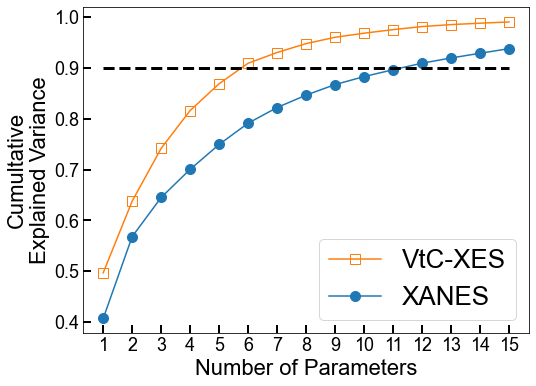

In [5]:
XES = np.array([c['XES_Normalized'] for c in X_data_classed])
XANES = np.array([c['XANES_Normalized'] for c in X_data_classed])

# pca
pca_all_xes = PCA()
XES_PCA = pca_all_xes.fit_transform(XES)
pca_all_xanes = PCA()
XANES_PCA = pca_all_xanes.fit_transform(XANES)

N = XANES_PCA.shape[1]

explained_var_xes = np.array([np.sum(pca_all_xes.explained_variance_ratio_[:i+1]) for i in range(N)])
explained_var_xanes = np.array([np.sum(pca_all_xanes.explained_variance_ratio_[:i+1]) for i in range(N)])

threshold_xes = np.where(explained_var_xes >= 0.9)[0][0]
threshold_xanes = np.where(explained_var_xanes >= 0.9)[0][0]

print(f"VtC-XES takes {threshold_xes+1} PCs to explain {explained_var_xes[threshold_xes]:.04f} variance")
print(f"XANES takes {threshold_xanes+1} PCs to explain {explained_var_xanes[threshold_xanes]:.04f} variance")

make_stacked_scree(pca_all_xes.explained_variance_ratio_, pca_all_xanes.explained_variance_ratio_, n=15)

# Coordination

* How does tricoordinate versus tetracoordinate compare?

In [73]:
X_coord, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XES',
                                                             method='UMAP')
X_coord, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XANES',
                                                                 method='UMAP')

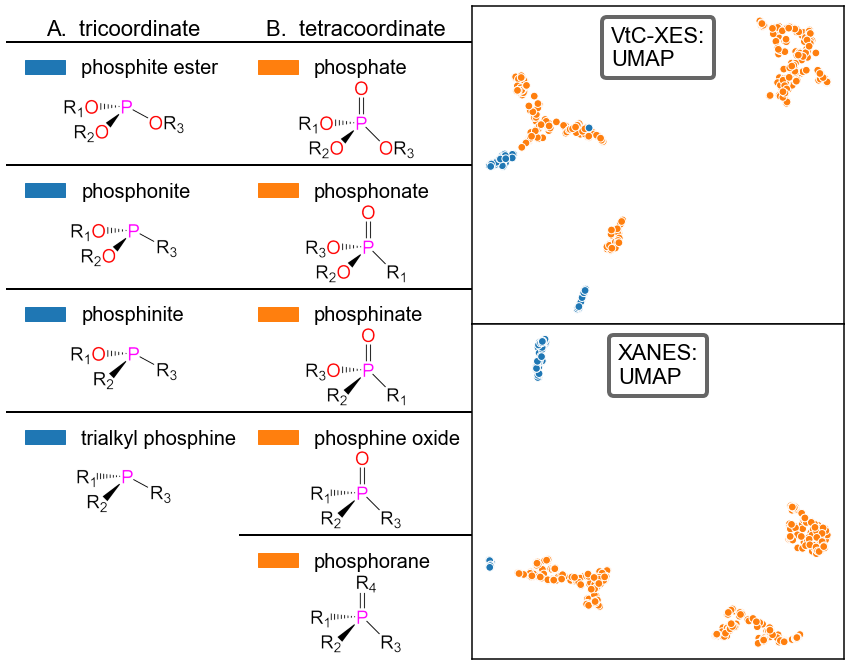

In [78]:
fig = plt.figure(figsize=(15,12))
asize = 0.4
spec = fig.add_gridspec(nrows=11, ncols=3,
                        width_ratios = [0.5, 0.5, 0.8],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0., hspace=0)

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = COORDCODES, coordcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2,j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        plt.axis('equal')
        # Hide spines
        set_spine_width(structax, width=2)
        turn_off_spines(structax, spines=['top','left','right'])
        if i == len(structure_list) - 1:
            structax.spines['bottom'].set_visible(False)
        turn_off_ticks(structax)

        # make legend
        legax = fig.add_subplot(spec[2*i + 1,j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.25),
                              fontsize=20, framealpha=0, frameon=False)
        # Hide spines
        set_spine_width(legax, width=2)
        turn_off_spines(legax, spines=['bottom','left','right'])
        turn_off_ticks(legax)
        
        if i == 0:
            legax.set_title(titles[j], fontsize=22)
            
ax = fig.add_subplot(spec[:6,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                              mode='XES', method='UMAP', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 'upper center'})
set_spine_width(ax, width=1.5)

ax = fig.add_subplot(spec[6:11,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                              mode='XANES', method='UMAP', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 'upper center'})
set_spine_width(ax, width=1.5)

plt.savefig(f'../Figures/coordination.png', dpi=1000, transparent=False, bbox_inches='tight')

## Oxidation within coordination

* Within tricoordination and tetracoordinate compounds, how does the increase in oxidation state affect the location in the t-SNE reduced space?

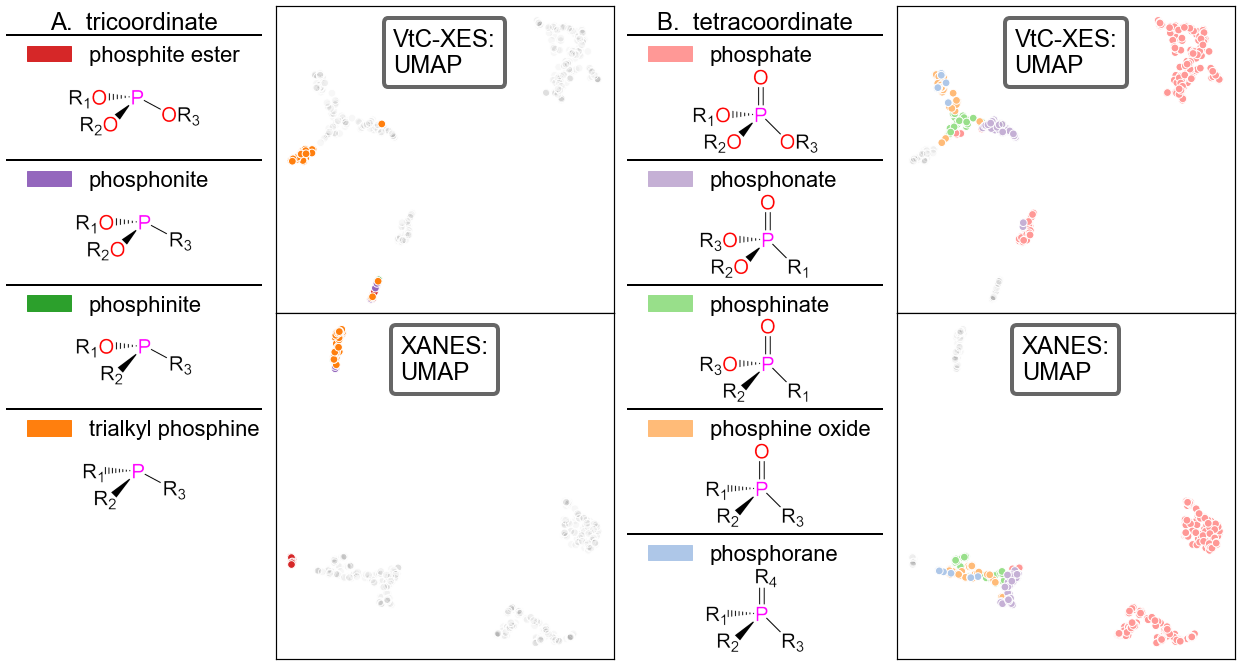

In [79]:
fig = plt.figure(figsize=(22,12))
asize = 0.3
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.6, 0.8, 0.6, 0.8],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = CLASSCODES, classcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        plt.axis('equal')
        turn_off_ticks(structax)
        set_spine_width(structax, width=2)
        turn_off_spines(structax, spines=['top','left','right'])
        if i == len(structure_list) - 1:
            structax.spines['bottom'].set_visible(False)
        
        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.3),
                              fontsize=22, framealpha=0, frameon=False)
        turn_off_ticks(legax)
        set_spine_width(legax, width=2)
        turn_off_spines(legax, spines=['bottom','left','right'])
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([1, 3]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                                  mode='XES', method='UMAP', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03, **{'loc': 'upper center'})
    set_spine_width(ax, width=1.2)
    add_point_pubchem_link(class_tsneplt, X_coord)

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                                  mode='XANES', method='UMAP', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03, **{'loc': 'upper center'})
    set_spine_width(ax, width=1.2)
    add_point_pubchem_link(class_tsneplt, X_coord)
    
plt.savefig(f'../Figures/oxidation.png', dpi=1000, transparent=False, bbox_inches='tight')

# Spaghetti based on chemical classes (within coordination)

* How do tricoordinate versus tetracoordinate compare spectrally?

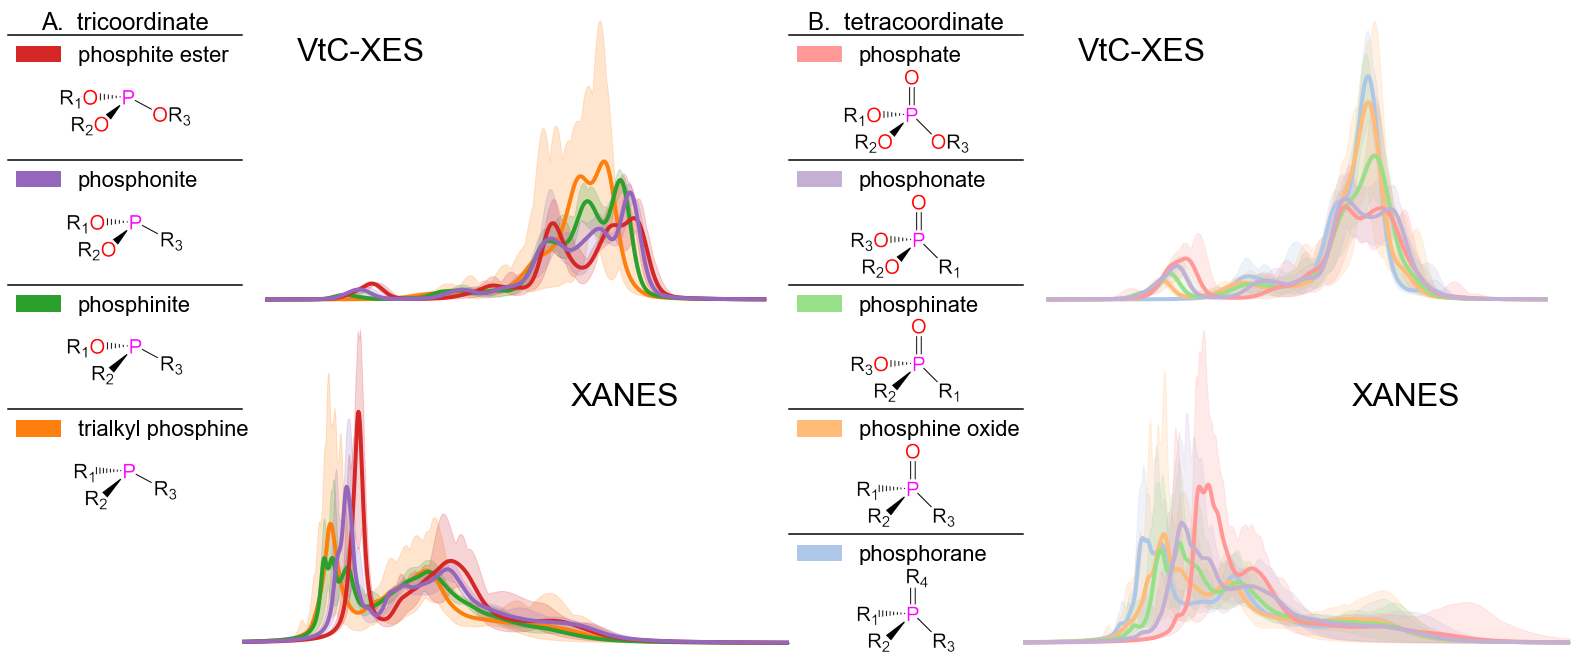

In [9]:
fig = plt.figure(figsize=(28,12))
asize = 0.3
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.3, 0.7, 0.3, 0.7],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0., hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = CLASSCODES, classcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        structax.axis('equal')
        turn_off_ticks(structax)
        turn_off_spines(structax)

        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                              fontsize=22, framealpha=0, frameon=False)
        turn_off_ticks(legax)
        turn_off_spines(legax, spines=['bottom','left','right'])
        set_spine_width(legax, width=1.5)
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([1, 3]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    
    binmap = {cid:v-1 for cid, v in classcodemap.items() if cid not in hiddencids}
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    
    spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES',
                                   colorcodemap=binmap, binmap=binmap,
                                   fontsize=26, linewidth=4, scalecolor=False,
                                   hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                   verbose=False)

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    
    spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                                   colorcodemap=binmap, binmap=binmap,
                                   fontsize=26, linewidth=4, scalecolor=False,
                                   hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                   verbose=False, energyrange=(2142,2175))
      
    
# plt.savefig(f'../Figures/SI_oxidation_spaghetti.png', dpi=800, transparent=False, bbox_inches='tight')

## Phosphate subclusters

* Why are the phosphates being sub-divided into three different clusters?

In [59]:
%matplotlib inline

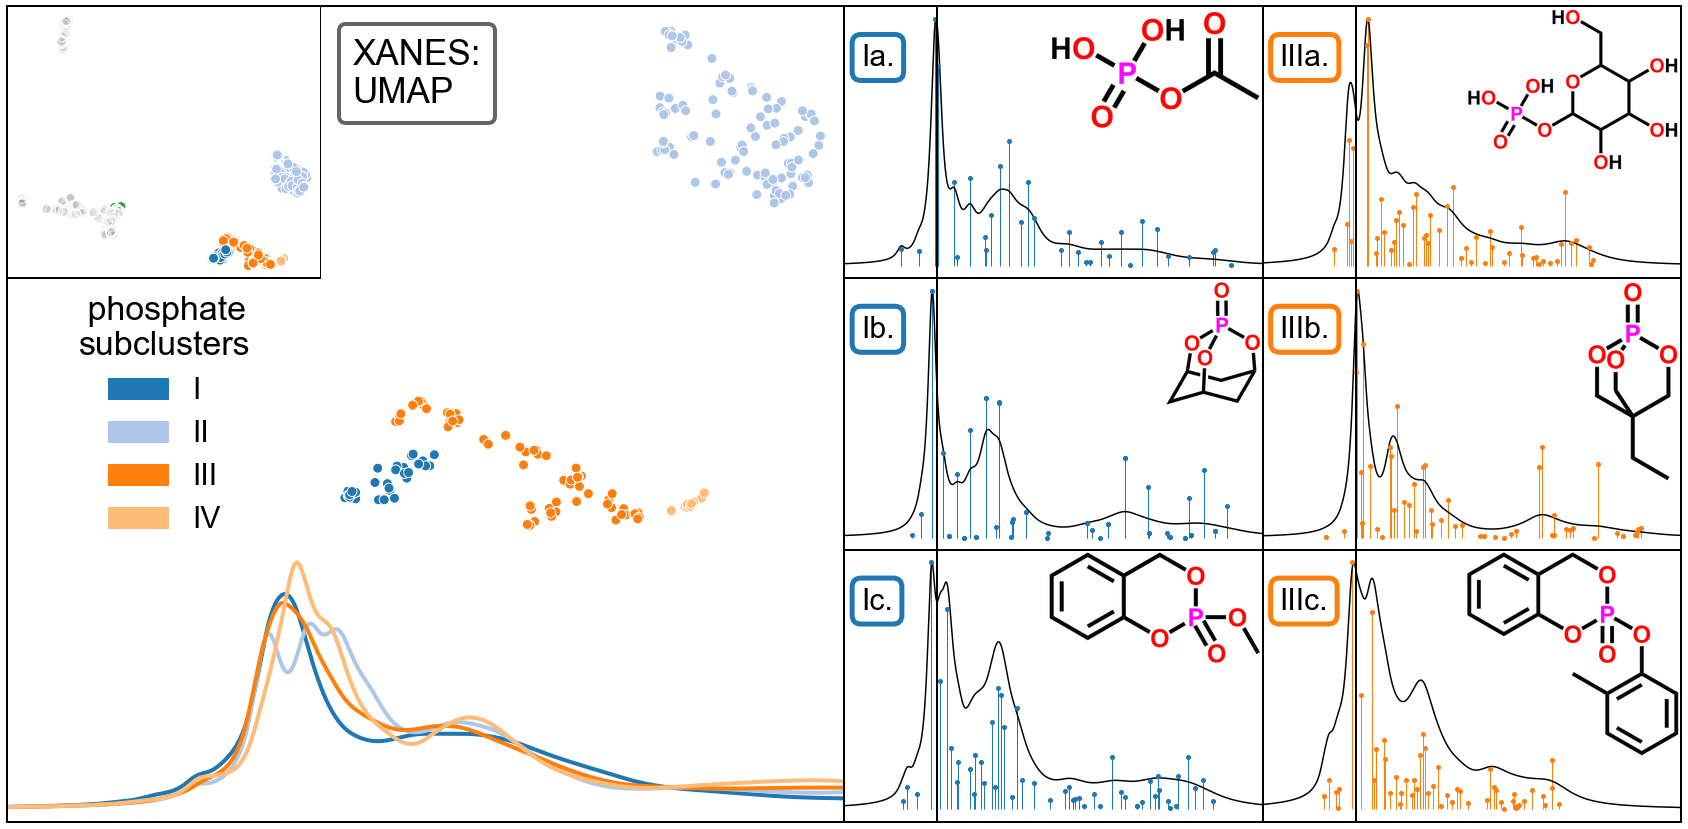

In [99]:
# kwargs options
kwargs = {'Class': ['phosphate'], 'loc':2, 'title': None}

# make figure
fig = plt.figure(figsize=(30,15))
spec = fig.add_gridspec(nrows=3, ncols=4, width_ratios=[0.6, 1.0, 0.8, 0.8])
plt.subplots_adjust(wspace=0, hspace=0)

############ create DBScan clusters
tsne_phosphates = np.array([XANES_tsnemap[c['CID']] for c in X_data_classed if c['Class'] == 'phosphate'])
cids_phosphates = [c['CID'] for c in X_data_classed if c['Class'] == 'phosphate']

dbscan_clustering = DBSCAN(eps=0.52, min_samples=1).fit(tsne_phosphates)
dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

############ plot all phosphates with clusters indicated by DBSCAN
phosphate_clustermap = {}
for c in X_data_classed:
    if c['Class'] == 'phosphate':
        phosphate_clustermap[c['CID']] = dbscan_clustermap[c['CID']] + 1
    else:
        phosphate_clustermap[c['CID']] = 0
              
select_clusters = np.unique(dbscan_clustering.labels_) + 1
select_clusters = select_clusters[:-1]
keys = {1:'I', 2:'II', 3:'III', 4:'IV', 5:'V', 6:'VI', 7:'VII'}

X_phosphate = [c for c in X_data_classed if phosphate_clustermap[c['CID']] in select_clusters]

phosphate_colorcodemap = {c['CID']:phosphate_clustermap[c['CID']] for c in X_data_classed \
                          if phosphate_clustermap[c['CID']] in select_clusters}
binmap = {k:v - 1 for k,v in phosphate_colorcodemap.items()}

# make legend
legax = fig.add_subplot(spec[1, 0])
patches = [mpatches.Patch(color=plt.cm.tab20(cluster - 1), label=keys[cluster])
           for cluster in select_clusters]
legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                      fontsize=30, framealpha=0, frameon=False,
                      title=' phosphate\nsubclusters', title_fontsize=34)
set_spine_width(legax, width=2)
turn_off_spines(legax, spines=['bottom', 'right'])
turn_off_ticks(legax)

# phosphate structure
# structure = Image.open(f'../Figures/chemdraw/phosphate.png')
# structure = resize_img(structure, ratio=(1,1.8))
structax = fig.add_subplot(spec[0, 0])
# structax.imshow(structure)
# structax.axis('equal')
tsne_plt = plot_dim_red((fig, structax), X_coord, XANES_tsnemap, size=100,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='UMAP', fontsize=35, show_legend=False,
                        edgecolors='w', **kwargs)
set_spine_width(structax, width=2)
turn_off_ticks(structax)

######################### examples
cluster_cids = np.array([[186, 120825, 119401],[466, 13869, 104993]])

# example spectra
cluster_counts = [np.sum(dbscan_clustering.labels_ == cluster) for cluster in [0, 1, 2]]
show_clusters = np.delete([0, 1, 2], np.argmax(cluster_counts))

labels = [[f'{keys[show_clusters[0] + 1]}a.', f'{keys[show_clusters[0] + 1]}b.',\
           f'{keys[show_clusters[0] + 1]}c.'],\
          [f'{keys[show_clusters[1] + 1]}a.', f'{keys[show_clusters[1] + 1]}b.',\
           f'{keys[show_clusters[1] + 1]}c.']]

options = kwargs
# options = Merge(kwargs, {'CID': cluster_cids.flatten(),
#                          'label': [ele.replace('.', '') for sublist in labels
#                                    for ele in sublist]})

############ zoomed in on clusters
ax = fig.add_subplot(spec[:2, 1])
# size = 120
tsne_plt = plot_dim_red((fig, ax), X_phosphate, XANES_tsnemap, size=100,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='UMAP', fontsize=35,
                        edgecolors='w', **options)
set_spine_width(ax, width=2)
turn_off_spines(ax, spines=['bottom', 'left'])
# add_point_pubchem_link(tsne_plt, X_phosphate)

############ spaghetti plot of average clusters indicated by DBSCAN
ax = fig.add_subplot(spec[2, :2])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                               colorcodemap=binmap, binmap=binmap, fontsize=26,
                               linewidth=4, energyrange=(2148,2162.5), scalecolor=False,
                               hiddenalpha=0, coloralpha=1.0, average_bins=True,
                               **kwargs)
## adding cluster II structure
# add_structure(fig, 'II', ax, resize=False, add_axes=True, chemdraw=True)
# t = ax.text(2158, 0.43, 'II.', ha="center", va="center", size=50,
#             bbox=dict(boxstyle="round,pad=0.3", ec=plt.cm.tab20(1), fc="w", lw=5))

# formatting axis
set_spine_width(ax, width=2)
turn_off_ticks(ax)
ax.set_xlabel(None)
turn_off_spines(ax, spines=['top'])

for j, cid_list in enumerate(cluster_cids):
    cluster = show_clusters[j]
    for i, cid in enumerate(cid_list):
        if i == 3:
            verbose = False
        else:
            verbose = False
        
        ax = fig.add_subplot(spec[i, j + 2])
        plot_spectrum_and_trans((fig, ax), compoundmap, cid, verbose=verbose,
                                mode='XANES', energyrange=(2148,2169), color=cluster,
                                link_pubchem=True, chemdraw=True, label=labels[j][i])
        set_spine_width(ax, width=2)
        turn_off_ticks(ax)
    
# plt.savefig(f'../Figures/phosphate_subclusters.png', dpi=800, transparent=False, bbox_inches='tight')

In [91]:
# # kwargs options
# kwargs = {'Class': ['phosphate'], 'loc':2, 'title': None}

# # make figure
# fig = plt.figure(figsize=(30,15))
# spec = fig.add_gridspec(nrows=3, ncols=4, width_ratios=[0.6, 1.0, 0.8, 0.8])
# plt.subplots_adjust(wspace=0, hspace=0)

# ############ create DBScan clusters
# tsne_phosphates = np.array([XANES_tsnemap[c['CID']] for c in X_data_classed if c['Class'] == 'phosphate'])
# cids_phosphates = [c['CID'] for c in X_data_classed if c['Class'] == 'phosphate']

# dbscan_clustering = DBSCAN(eps=3.2, min_samples=1).fit(tsne_phosphates)
# dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

# ############ plot all phosphates with clusters indicated by DBSCAN
# phosphate_clustermap = {}
# for c in X_data_classed:
#     if c['Class'] == 'phosphate':
#         phosphate_clustermap[c['CID']] = dbscan_clustermap[c['CID']] + 1
#     else:
#         phosphate_clustermap[c['CID']] = 0
              
# select_clusters = [1,2,3]
# keys = {1:'I', 2:'II', 3:'III'}

# X_phosphate = [c for c in X_data_classed if phosphate_clustermap[c['CID']] in select_clusters]

# phosphate_colorcodemap = {c['CID']:phosphate_clustermap[c['CID']] for c in X_data_classed \
#                           if phosphate_clustermap[c['CID']] in select_clusters}
# binmap = {k:v - 1 for k,v in phosphate_colorcodemap.items()}

# # make legend
# legax = fig.add_subplot(spec[1, 0])
# patches = [mpatches.Patch(color=plt.cm.tab20(cluster - 1), label=keys[cluster])
#            for cluster in select_clusters]
# legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
#                       fontsize=30, framealpha=0, frameon=False,
#                       title=' phosphate\nsubclusters', title_fontsize=34)
# set_spine_width(legax, width=2)
# turn_off_spines(legax, spines=['bottom', 'right'])
# turn_off_ticks(legax)

# # phosphate structure
# structure = Image.open(f'../Figures/chemdraw/phosphate.png')
# structure = resize_img(structure, ratio=(1,1.8))
# structax = fig.add_subplot(spec[0, 0])
# structax.imshow(structure)
# structax.axis('equal')
# set_spine_width(structax, width=2)
# turn_off_ticks(structax)

# ######################### examples
# cluster_cids = np.array([[186, 120825, 119401],[466, 13869, 104993]])

# # example spectra
# cluster_counts = [np.sum(dbscan_clustering.labels_ == cluster) for cluster in [0, 1, 2]]
# show_clusters = np.delete([0, 1, 2], np.argmax(cluster_counts))

# labels = [[f'{keys[show_clusters[0] + 1]}a.', f'{keys[show_clusters[0] + 1]}b.',\
#            f'{keys[show_clusters[0] + 1]}c.'],\
#           [f'{keys[show_clusters[1] + 1]}a.', f'{keys[show_clusters[1] + 1]}b.',\
#            f'{keys[show_clusters[1] + 1]}c.']]

# options = Merge(kwargs, {'CID': cluster_cids.flatten(),
#                          'label': [ele.replace('.', '') for sublist in labels
#                                    for ele in sublist]})

# ############ zoomed in on clusters
# ax = fig.add_subplot(spec[:2, 1])
# # size = 120
# tsne_plt = plot_dim_red((fig, ax), X_phosphate, XANES_tsnemap, size=100,
#                         colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
#                         mode='XANES', method='t-SNE', fontsize=35,
#                         edgecolors='w', **options)
# set_spine_width(ax, width=2)
# turn_off_spines(ax, spines=['bottom', 'left'])
# # add_point_pubchem_link(tsne_plt, X_phosphate)

# ############ spaghetti plot of average clusters indicated by DBSCAN
# ax = fig.add_subplot(spec[2, :2])
# spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
#                                colorcodemap=binmap, binmap=binmap, fontsize=26,
#                                linewidth=4, energyrange=(2148,2162.5), scalecolor=False,
#                                hiddenalpha=0, coloralpha=1.0, average_bins=True,
#                                **kwargs)
# ## adding cluster II structure
# add_structure(fig, 'II', ax, resize=False, add_axes=True, chemdraw=True)
# t = ax.text(2158, 0.43, 'II.', ha="center", va="center", size=50,
#             bbox=dict(boxstyle="round,pad=0.3", ec=plt.cm.tab20(1), fc="w", lw=5))

# # formatting axis
# set_spine_width(ax, width=2)
# turn_off_ticks(ax)
# ax.set_xlabel(None)
# turn_off_spines(ax, spines=['top'])

# for j, cid_list in enumerate(cluster_cids):
#     cluster = show_clusters[j]
#     for i, cid in enumerate(cid_list):
#         if i == 3:
#             verbose = False
#         else:
#             verbose = False
        
#         ax = fig.add_subplot(spec[i, j + 2])
#         plot_spectrum_and_trans((fig, ax), compoundmap, cid, verbose=verbose,
#                                 mode='XANES', energyrange=(2148,2169), color=cluster,
#                                 link_pubchem=True, chemdraw=True, label=labels[j][i])
#         set_spine_width(ax, width=2)
#         turn_off_ticks(ax)
    
# # plt.savefig(f'../Figures/phosphate_subclusters.png', dpi=800, transparent=False, bbox_inches='tight')

### Charge Analysis

In [46]:
import re

def parse_esp_file(compound):
    """Esp file parser."""
    filename = f'{compound}.esp'
    if os.path.exists(f'ProcessedData/{filename}'):
        with open(f'ProcessedData/{filename}') as f:
            data = f.read().splitlines()
            split_data = np.array([re.split('\s+', line) for i, line in enumerate(data) if i >= 2])
            atoms = split_data[:, 0]
            coordinates = np.array(split_data[:, 1:-1], dtype=float)
            charges = np.array(split_data[:, -1], dtype=float)
            parsed = []
            for i in range(len(split_data)):
                parsed.append({'atom': atoms[i], 'coords': coordinates[i], 'charge': charges[i]})
            return parsed
    else:
        # no esp file available
        return None

coord_to_charge_map = {}
cids = []
for i in range(len(X_phosphate)):
    cid = X_phosphate[i]['CID']
    data = parse_esp_file(cid)
    if data is not None:
        cids.append(cid)
        coord_to_charge_map[cid] = data

In [47]:
colorcode = {'P': 'magenta', 'O': 'red', 'C': 'black',
             'H': 'gray', 'N': 'blue', 'Cl': 'green',
             'S': 'yellow', 'Br': 'purple'}

def get_plot_data(atom_list):
    points = [atom['coords'] for atom in atom_list]
    colors = [colorcode[atom['atom']] for atom in atom_list]
    sizes = [PERIODIC_MAP[atom['atom']]*20 for atom in atom_list]
    labels = [atom['atom'] for atom in atom_list]
    return points, colors, sizes, labels

In [55]:
# oxygen_chargemap = {59: -0.436757, 119401: -0.357756, 1055:-0.381599,
#                     10400369: -0.363783, 1015: -0.463196, 2526:-0.492969, 
#                     14056322: -0.463537, 1005: -0.309366, 724: -0.367014,
#                     11987823: -0.431874, 105: -0.406114, 11207678: -0.472358,
#                     14892896: -0.414534, 186: -0.476775, 12573513: -0.34068,
#                     120420: -0.360212, 10541: -0.410917, 120825: -0.555858,
#                     6535:-0.427642, 105047: -0.533048, 10107: -0.532961,
#                     13708: -0.35226, 1034: -0.499411, 278: -0.441512,
#                     121947: -0.413273, 2115: -0.32574, 11988266: -0.385657,
#                     104993: -0.310225, 12241336: -0.334938, 378: -0.361742,
#                     729: -0.354767, 122250: -0.422716, 13869: -0.46293,
#                     3418: -0.33781, 12241338: -0.37266, 466: -0.473128,
#                     12793: -0.396437, 123912: -0.390308, 11242708: -0.402011,
#                     15066: -0.460691, 127766: -0.342639, 104885: -0.398887,
#                     122271: -0.387735, 107737: -0.384947, 1016: -0.475444,
#                     151197: -0.437754, 151187: -0.390723, 11276402: -0.404778,             
#                     110532: -0.373992, 669: -0.456578, 529: -0.386767,
#                     135451578: -0.402029, 106625: -0.427132, 123732: -0.50391,
#                     208: -0.359653, 106: -0.436404, 122357: -0.452002,
#                     1137: -0.395484, 11458565: -0.389966, 668: -0.329657,
#                     13130: -0.37304, 150: -0.39922, 150629: -0.366023,
#                     11550267: -0.343684, 5958: -0.413122, 792: -0.383197,
#                     216: -0.429845, 151104: -0.332726, 120985: -0.386425,
#                     1053: -0.43698
# }

59


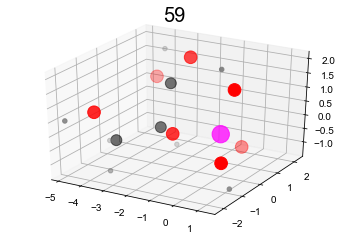

In [48]:
i = 0
for cid in cids[i:i + 1]:
    print(cid)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    points, colors, sizes, labels = get_plot_data(coord_to_charge_map[cid])
    dots = ax.scatter(*zip(*points), s=sizes, c=colors, label=labels)
    ax.set_title(cid, fontsize=20)
    add_charge_label(dots, coord_to_charge_map[cid])

In [54]:
# make_charge_hist(plt.subplots(figsize=(12,6)), oxygen_chargemap,
#                  colorcodemap=phosphate_clustermap,
#                  bins=25, atom='O', fontsize=20)
# plt.savefig(f'../Figures/SI_O_charge_hist.png', dpi=800, bbox_inches='tight')

[[  62773 6107844   21804    3039    7925]
 [  17280    4420   81525   16769 6433329]]
[[ 3034794   439452   439276    74188   439162]
 [    1055     1051 21896400      561 45934311]]
[[      59   160886     2526   439278    83430]
 [  439236   440043     1005    99058 44610740]]
[[  439871     6535   440194   440102    82641]
 [23724607    23353  5371562   440236 54679073]]


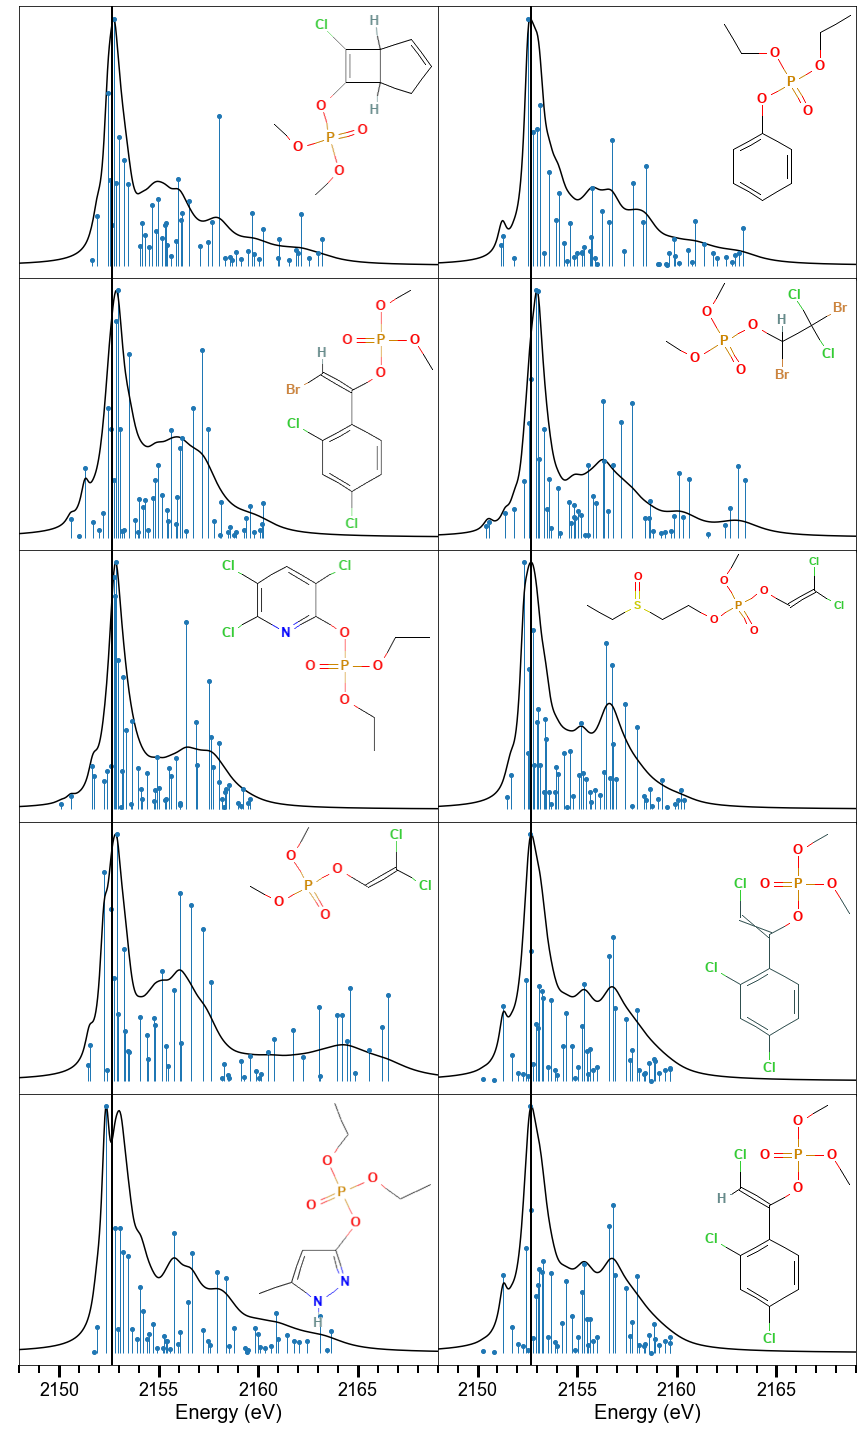

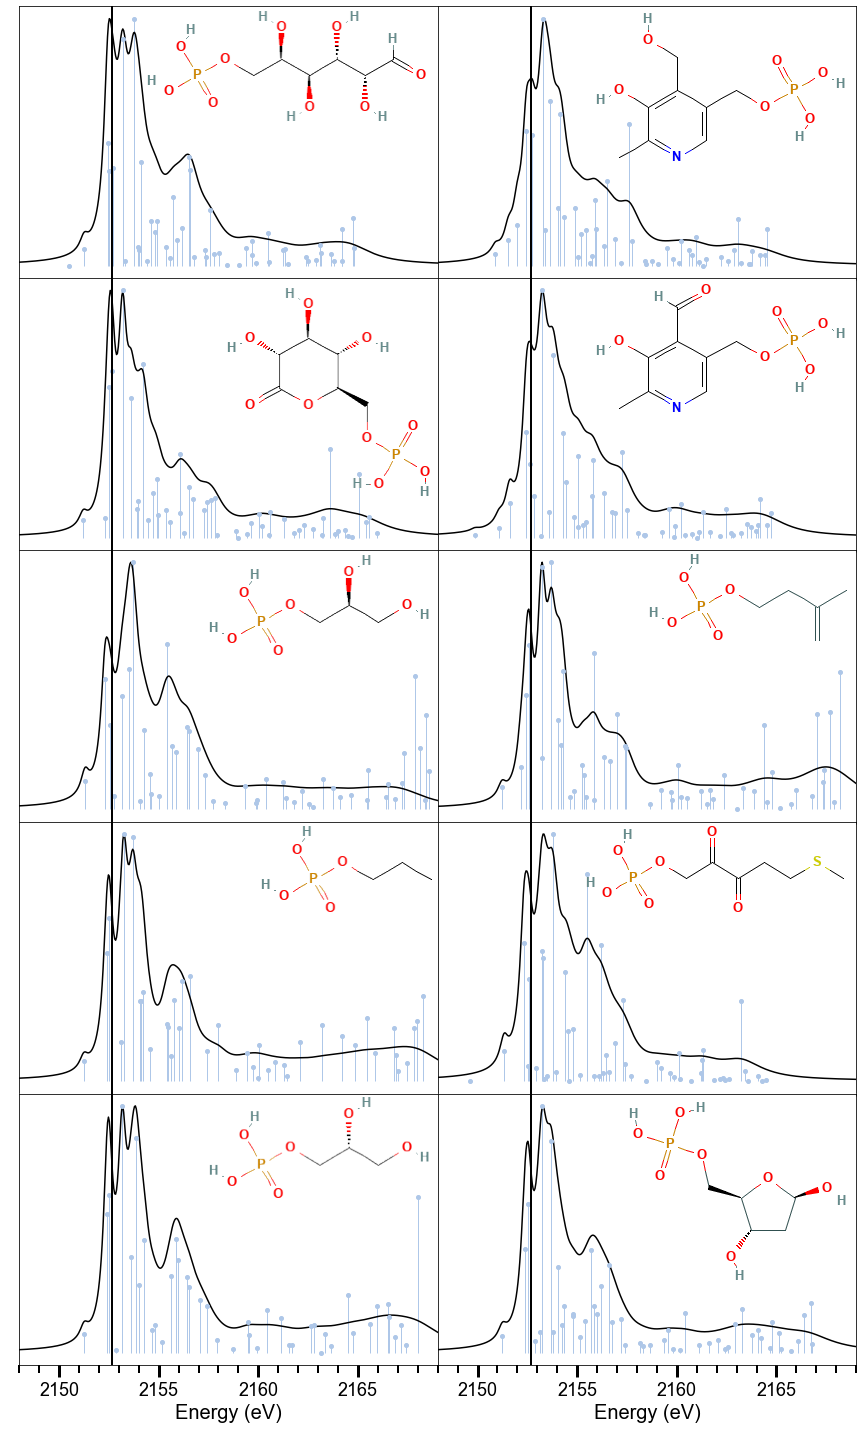

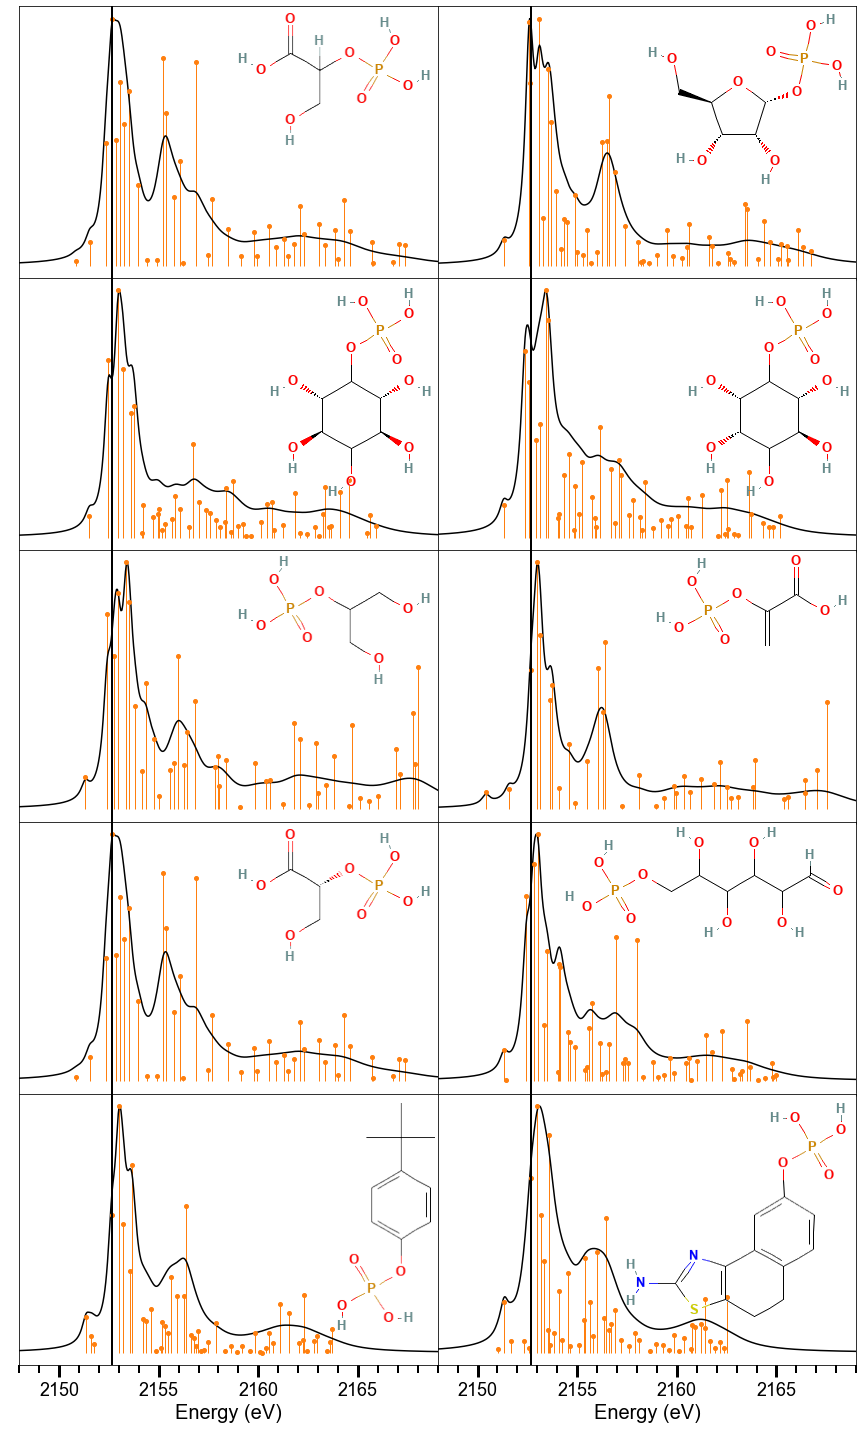

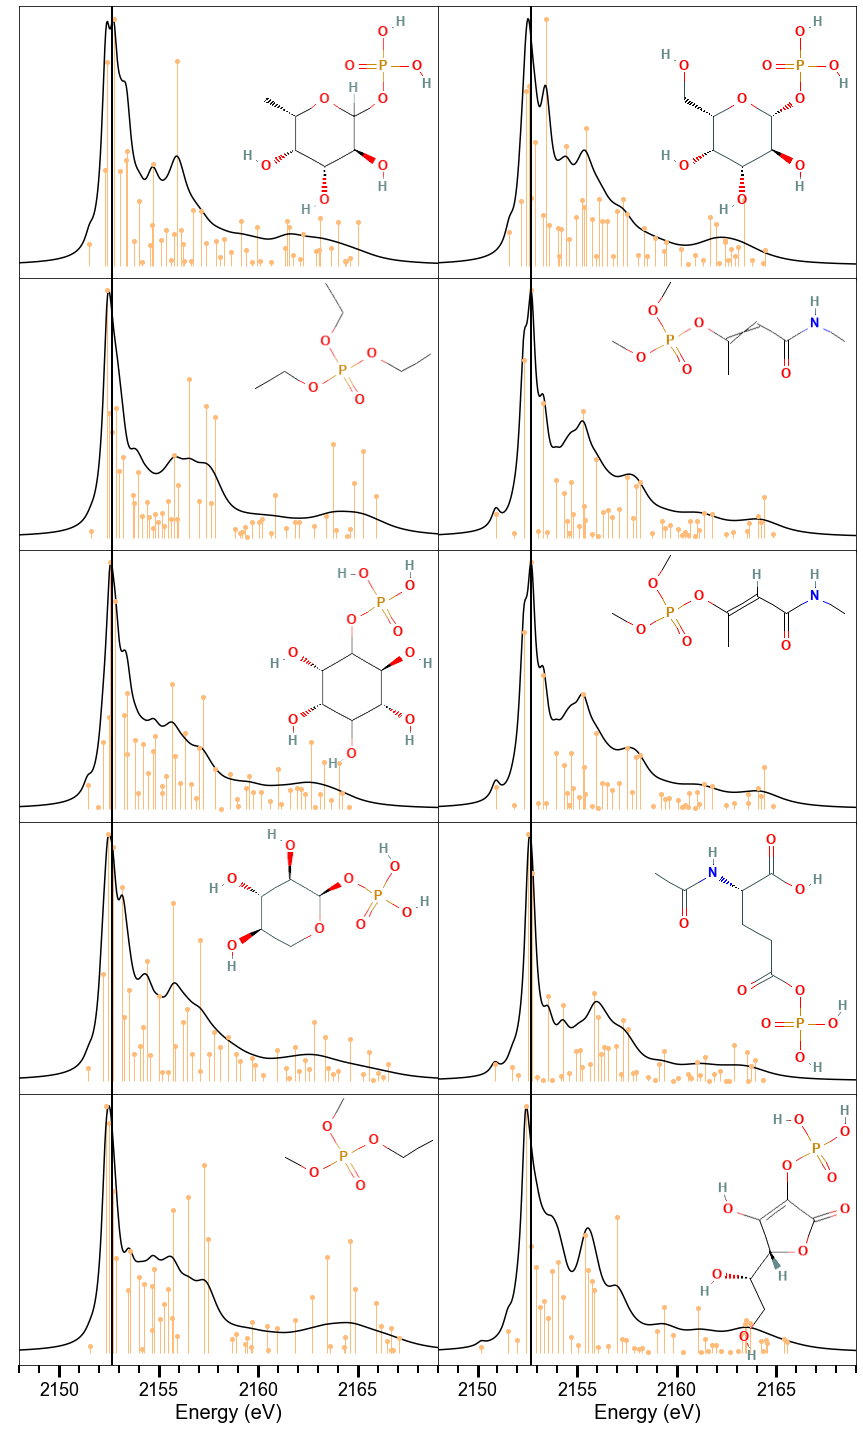

In [120]:
### SI figures
for select in [0, 1, 2, 3]:
    cids = []
    for cid, cluster in dbscan_clustermap.items():
        if cluster == select and cid not in cluster_cids:
#         if cluster == select and compoundmap[cid]['Charge'] != -1 and cid not in cluster_cids:
            cids += [cid]

    if len(cids) < 10:
        N = len(cids)//2
    else:
        N = 5
    cids = np.array(cids[:N*2]).reshape((2,N))
    print(cids)
    
    fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15,N*5))
    plt.subplots_adjust(wspace=0, hspace=0)

    for cluster, cid_list in enumerate(cids):
        for i, cid in enumerate(cid_list):
            if i == N-1:
                verbose = True
            else:
                verbose = False
            plot_spectrum_and_trans((fig, axes[i, cluster]), compoundmap, cid, verbose=verbose,
                                    mode='XANES', energyrange=(2148,2169), color=select,
                                    link_pubchem=True, chemdraw=False, resize=True)
    plt.savefig(f'../Figures/SI_phosphate_cluster_{select + 1}.png', dpi=800, bbox_inches='tight')

## Sulfur-included bonding environment

* How does changing the ligand from carbon to sulfur impact the t-SNE clustering?

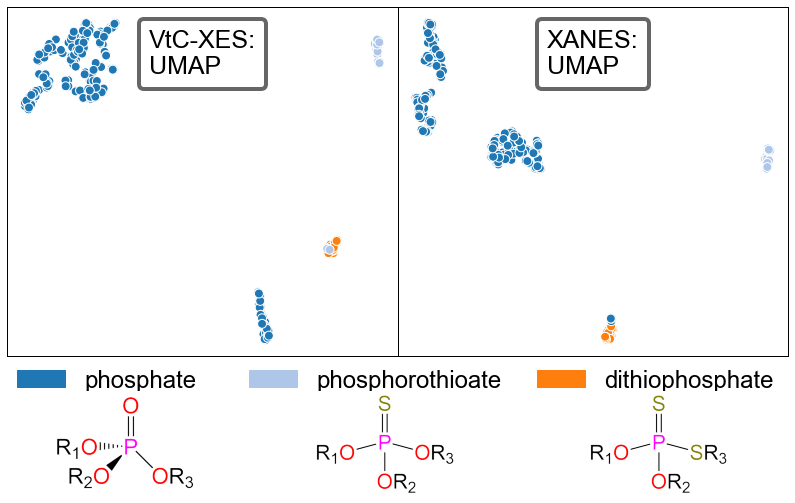

In [110]:
# sulfur subclasses
codemap = sulfurcodemap
labels = ['phosphate', 'phosphorothioate', 'dithiophosphate']
bin_names = list(SULFURCODES.keys())
N = len(labels)

fig = plt.figure(figsize=(14,9))
spec = fig.add_gridspec(nrows=3, ncols=6, width_ratios=[1, 0.8, 1.2, 1, 1, 1],
                        height_ratios=[1, 0.1, 0.3])
plt.subplots_adjust(wspace=0, hspace=0)

kwargs = {'Class': labels}

# X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
#                                                               perplexity=20, method='umap', **kwargs)
# X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
#                                                                   perplexity=18, method='umap', **kwargs)

structures = [plt.imread(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]

for i, structure in enumerate(structures):
    # make legend
    legax = fig.add_subplot(spec[1, 2*i:2*i + 2])
    patches = [mpatches.Patch(color=plt.cm.tab20(i), label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                              fontsize=24, framealpha=0, frameon=False)
    turn_off_ticks(legax)
    turn_off_spines(legax)

    # show structure
    structax = fig.add_subplot(spec[2, 2*i:2*i + 2])
    structax.imshow(structures[i])
    turn_off_ticks(structax)
    turn_off_spines(structax)

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col1, col2 = 0, 3
        options = {'loc':'upper center'}
    else:
        tsnemap = XANES_tsnemap
        col1, col2 = 3, 6
        options = {'loc': 'upper center'}
    #################### tsne plot
    ax = fig.add_subplot(spec[0, col1:col2])
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=80,
                            colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='UMAP', fontsize=25, edgecolors='w',
                            **Merge(kwargs, options))
    set_spine_width(ax, width=1.)
    add_point_pubchem_link(tsne_plt, X_subset)
    
plt.savefig(f'../Figures/sulfur.png', dpi=1000, transparent=False, bbox_inches='tight')

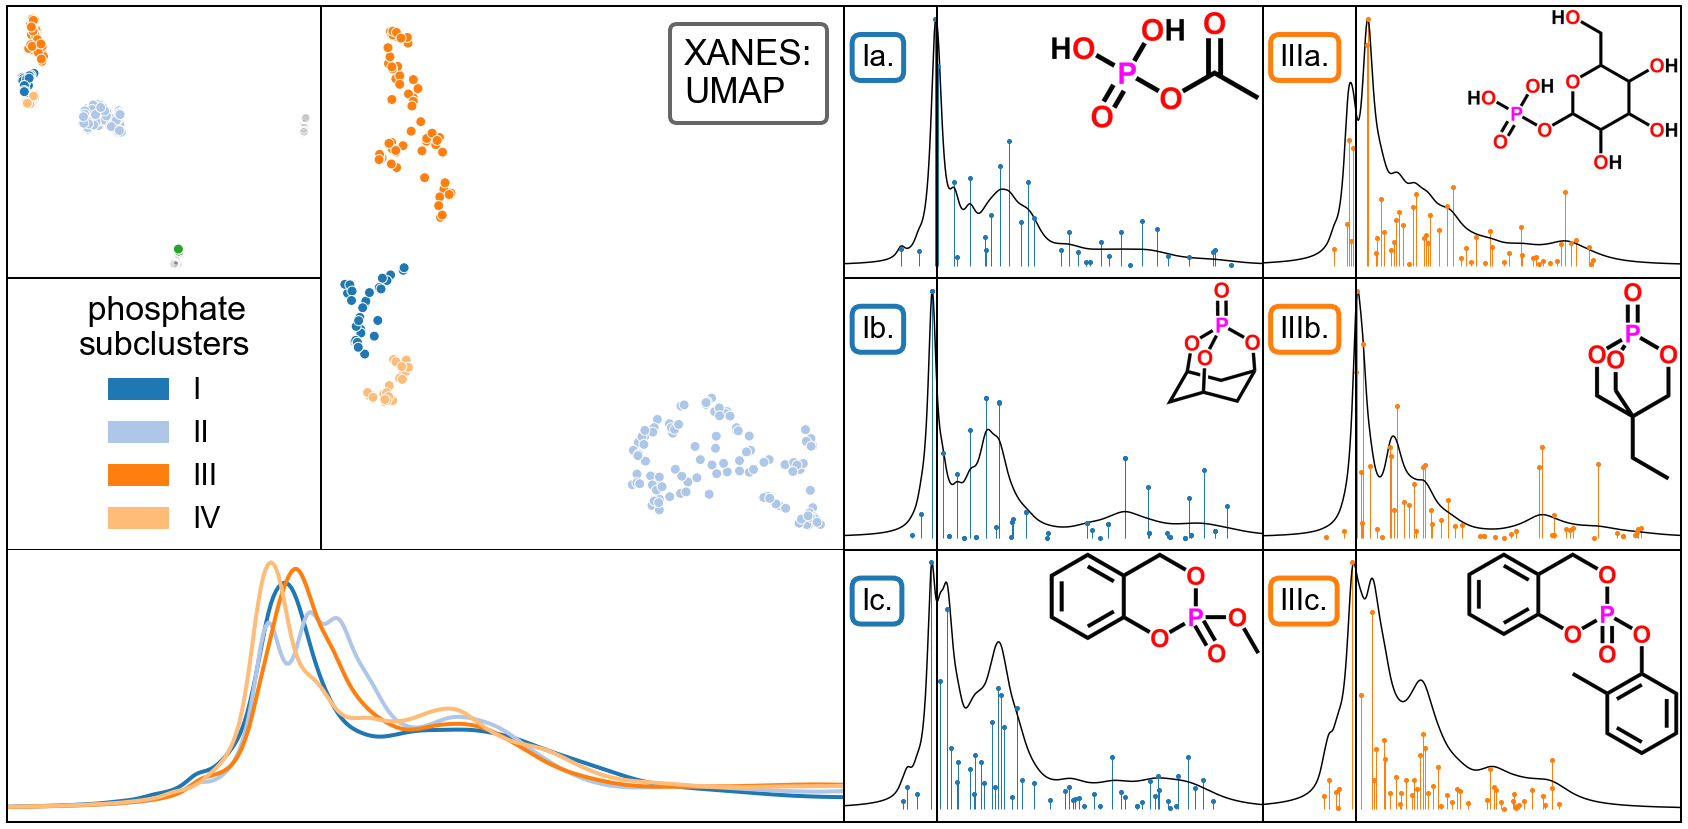

In [116]:
# kwargs options
kwargs = {'Class': ['phosphate'], 'loc':1, 'title': None}

# make figure
fig = plt.figure(figsize=(30,15))
spec = fig.add_gridspec(nrows=3, ncols=4, width_ratios=[0.6, 1.0, 0.8, 0.8])
plt.subplots_adjust(wspace=0, hspace=0)

############ create DBScan clusters
tsne_phosphates = np.array([XANES_tsnemap[c['CID']] for c in X_subset if c['Class'] == 'phosphate'])
cids_phosphates = [c['CID'] for c in X_subset if c['Class'] == 'phosphate']

dbscan_clustering = DBSCAN(eps=0.6, min_samples=1).fit(tsne_phosphates)
dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

############ plot all phosphates with clusters indicated by DBSCAN
phosphate_clustermap = {}
for c in X_subset:
    if c['Class'] == 'phosphate':
        phosphate_clustermap[c['CID']] = dbscan_clustermap[c['CID']] + 1
    else:
        phosphate_clustermap[c['CID']] = 0
              
select_clusters = np.unique(dbscan_clustering.labels_) + 1
select_clusters = select_clusters[:-1]
keys = {1:'I', 2:'II', 3:'III', 4:'IV', 5:'V', 6:'VI', 7:'VII'}

X_phosphate = [c for c in X_subset if phosphate_clustermap[c['CID']] in select_clusters]

phosphate_colorcodemap = {c['CID']:phosphate_clustermap[c['CID']] for c in X_subset \
                          if phosphate_clustermap[c['CID']] in select_clusters}
binmap = {k:v - 1 for k,v in phosphate_colorcodemap.items()}

# make legend
legax = fig.add_subplot(spec[1, 0])
patches = [mpatches.Patch(color=plt.cm.tab20(cluster - 1), label=keys[cluster])
           for cluster in select_clusters]
legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                      fontsize=30, framealpha=0, frameon=False,
                      title=' phosphate\nsubclusters', title_fontsize=34)
set_spine_width(legax, width=2)
# turn_off_spines(legax, spines=['bottom', 'right'])
turn_off_ticks(legax)

# phosphate structure
# structure = Image.open(f'../Figures/chemdraw/phosphate.png')
# structure = resize_img(structure, ratio=(1,1.8))
structax = fig.add_subplot(spec[0, 0])
# structax.imshow(structure)
# structax.axis('equal')
tsne_plt = plot_dim_red((fig, structax), X_subset, XANES_tsnemap, size=100,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='UMAP', fontsize=35, show_legend=False,
                        edgecolors='w', **kwargs)
# tsne_plt = plot_dim_red((fig, structax), X_subset, XANES_tsnemap, size=80,
#                          colorcodemap=sulfurcodemap, coloralpha=1., hiddenalpha=0.03,
#                          mode='XANES', method='UMAP', fontsize=25, edgecolors='w',
#                          show_legend=False)
set_spine_width(structax, width=2)
turn_off_ticks(structax)

######################### examples
cluster_cids = np.array([[186, 120825, 119401],[466, 13869, 104993]])

# example spectra
cluster_counts = [np.sum(dbscan_clustering.labels_ == cluster) for cluster in [0, 1, 2]]
show_clusters = np.delete([0, 1, 2], np.argmax(cluster_counts))

labels = [[f'{keys[show_clusters[0] + 1]}a.', f'{keys[show_clusters[0] + 1]}b.',\
           f'{keys[show_clusters[0] + 1]}c.'],\
          [f'{keys[show_clusters[1] + 1]}a.', f'{keys[show_clusters[1] + 1]}b.',\
           f'{keys[show_clusters[1] + 1]}c.']]

options = kwargs
# options = Merge(kwargs, {'CID': cluster_cids.flatten(),
#                          'label': [ele.replace('.', '') for sublist in labels
#                                    for ele in sublist]})

############ zoomed in on clusters
ax = fig.add_subplot(spec[:2, 1])
# size = 120
tsne_plt = plot_dim_red((fig, ax), X_phosphate, XANES_tsnemap, size=100,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='UMAP', fontsize=35,
                        edgecolors='w', **options)
set_spine_width(ax, width=2)
# turn_off_spines(ax, spines=['bottom', 'left'])
# add_point_pubchem_link(tsne_plt, X_phosphate)

############ spaghetti plot of average clusters indicated by DBSCAN
ax = fig.add_subplot(spec[2, :2])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                               colorcodemap=binmap, binmap=binmap, fontsize=26,
                               linewidth=4, energyrange=(2148,2162.5), scalecolor=False,
                               hiddenalpha=0, coloralpha=1.0, average_bins=True,
                               **kwargs)
## adding cluster II structure
# add_structure(fig, 'II', ax, resize=False, add_axes=True, chemdraw=True)
# t = ax.text(2158, 0.43, 'II.', ha="center", va="center", size=50,
#             bbox=dict(boxstyle="round,pad=0.3", ec=plt.cm.tab20(1), fc="w", lw=5))

# formatting axis
set_spine_width(ax, width=2)
turn_off_ticks(ax)
ax.set_xlabel(None)
turn_off_spines(ax, spines=['top'])

for j, cid_list in enumerate(cluster_cids):
    cluster = show_clusters[j]
    for i, cid in enumerate(cid_list):
        if i == 3:
            verbose = False
        else:
            verbose = False
        
        ax = fig.add_subplot(spec[i, j + 2])
        plot_spectrum_and_trans((fig, ax), compoundmap, cid, verbose=verbose,
                                mode='XANES', energyrange=(2148,2169), color=cluster,
                                link_pubchem=True, chemdraw=True, label=labels[j][i])
        set_spine_width(ax, width=2)
        turn_off_ticks(ax)
    
# plt.savefig(f'../Figures/phosphate_subclusters.png', dpi=800, transparent=False, bbox_inches='tight')

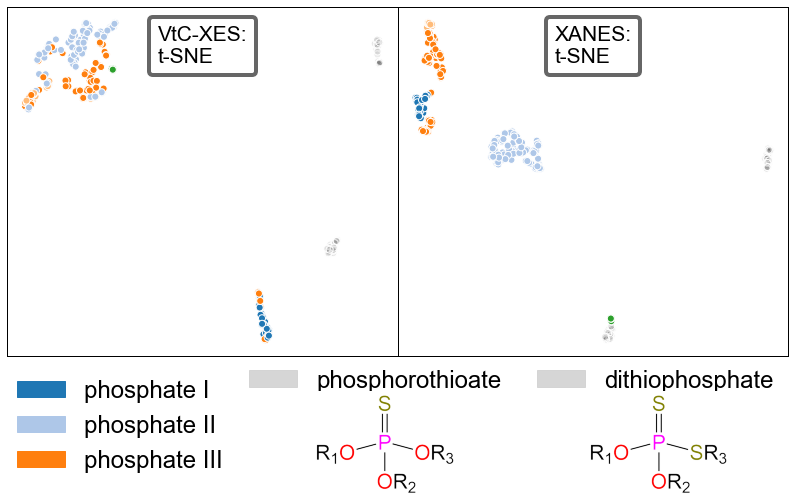

In [103]:
fig = plt.figure(figsize=(14,9))
spec = fig.add_gridspec(nrows=3, ncols=6, width_ratios=[1, 0.8, 1.2, 1, 1, 1],
                        height_ratios=[1, 0.1, 0.3])
plt.subplots_adjust(wspace=0, hspace=0)

for i, structure in enumerate(structures):
    # make legend
    if i == 0:
        legax = fig.add_subplot(spec[1:3, 2*i:2*i + 2])
        patches = [mpatches.Patch(color=plt.cm.tab20(0), label=(labels[i].replace('_',' ') + ' I')),
                   mpatches.Patch(color=plt.cm.tab20(1), label=(labels[i].replace('_',' ') + ' II')),
                   mpatches.Patch(color=plt.cm.tab20(2), label=(labels[i].replace('_',' ') + ' III'))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.5),
                              fontsize=24, framealpha=0, frameon=False)
        turn_off_ticks(legax)
        turn_off_spines(legax)
    
    else:
        legax = fig.add_subplot(spec[1, 2*i:2*i + 2])
        
        color = (210/255., 210/255., 210/255., 0.9)
        patches = [mpatches.Patch(color=color, label=(labels[i].replace('_',' ')))]
    
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                              fontsize=24, framealpha=0, frameon=False)
        turn_off_ticks(legax)
        turn_off_spines(legax)

        # show structure
        structax = fig.add_subplot(spec[2, 2*i:2*i + 2])
        structax.imshow(structures[i])
        turn_off_ticks(structax)
        turn_off_spines(structax)

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col1, col2 = 0, 3
    else:
        tsnemap = XANES_tsnemap
        col1, col2 = 3, 6
    #################### tsne plot
    ax = fig.add_subplot(spec[0, col1:col2])
    hiddenCIDS += [cid for cid, cluster in phosphate_clustermap.items() if cluster == 0]
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=50, hiddencids=hiddenCIDS,
                            colorcodemap=phosphate_clustermap, coloralpha=1., hiddenalpha=0.08,
                            mode=mode, method='t-SNE', fontsize=21, edgecolors='w',
                            **Merge(kwargs, options))
    set_spine_width(ax, width=1.)
    
# plt.savefig(f'../Figures/sulfur_color_by_phosphates.png', dpi=800, transparent=False, bbox_inches='tight')

# OH group dependence

* How do hydroxyls, i.e., an H instead of a C, impact the spectra?

* Does UMAP perform as well as t-SNE?

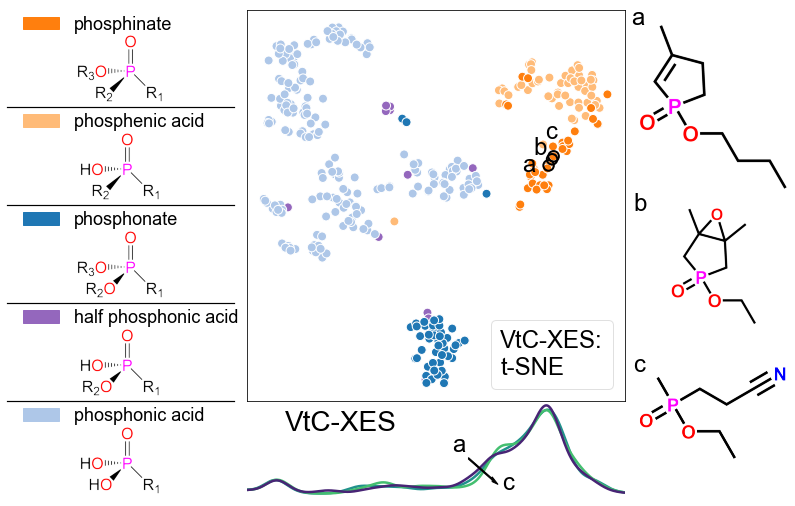

In [23]:
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'half_phosphonic_acid', 'phosphonic_acid']
structures = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]
colorcode, codemap = OHCODES, ohcodemap
N = len(labels)

method = 't-SNE'

########## set up figure with axes
fig = plt.figure(figsize=(14, 9))
ratio = 0.3
spec = fig.add_gridspec(nrows=N*2, ncols=3, width_ratios=[0.6, 1, 0.4],
                        height_ratios=[ratio, 1, ratio, 1, ratio, 1, ratio, 1, ratio, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

########## set up formatting kwargs and variables
kwargs = {'Class': labels, 'loc':4, 'title': ''}

########## get reuced spaces with corresponding maps
# X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
#                                                               method=method, **kwargs)
# X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
#                                                                   method=method, **kwargs)
cid_subset = [c['CID'] for c in X_data_classed if c['Class'] in labels]

########## make first column with structures
for i, structure in enumerate(structures):
    # show structure
    structax = fig.add_subplot(spec[2*i+1,0])
    structax.imshow(structures[i])
    structax.axis('equal')
    # Hide spines
    turn_off_spines(structax)
    turn_off_ticks(structax)
        
    # make legend
    legax = fig.add_subplot(spec[2*i,0])
    patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[i]] - 1),
                              label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.35),
                          fontsize=18, framealpha=0, frameon=False)
    # Hide spines
    set_spine_width(legax, width=1.2)
    turn_off_spines(legax, spines=['bottom','left','right'])
    if i == 0:
        turn_off_spines(legax, spines=['top'])
    turn_off_ticks(legax)
    
########### set-up example settings
select_cids = [312437, 88779457, 10397098]
label = ['a', 'b', 'c']
colorcodemap = {312437:0.1, 88779457:0.5, 10397098:0.7}
offsets = [(-25, -20), (-12, 0), (3, 22)]
energyrange = (2119, 2142)
tsnemap = XES_tsnemap   

###### spaghetti plot of selected cids
ax = fig.add_subplot(spec[N*2-2:, 1])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES', scalecolor=False,
                                colorcodemap=colorcodemap, colormap=plt.cm.viridis,
                                linewidth=2.5, hiddenalpha=0, coloralpha=1.0, verbose=False,
                                energyrange=energyrange, **Merge(kwargs, options))

###### drawing arrow and annotating
x, y, dx, dy = 2132.5, 1.18, 1.8, -0.13
arr = mpl.patches.Arrow(x, y, dx, dy, width=0.04, linestyle='-',
                        edgecolor='k', facecolor='k', zorder=5)
ax.add_patch(arr)
ax.annotate('a', (x, y), ha='center', va='bottom',
            size=24, xytext=(-10, 2), textcoords='offset points')
ax.annotate('c', (x + dx, y + dy), ha='center', va='bottom',
            size=24, xytext=(10, -10), textcoords='offset points')

######## select options for the 2D plot
options = Merge(kwargs, {'CID': select_cids, 'offsets':offsets, 'label':label})
subax = fig.add_subplot(spec[:N*2-2, 1])
            
#################### tsne plot   
tsne_plt = plot_dim_red((fig, subax), X_subset, tsnemap, size=80, 
                        colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                        mode='XES', method=method, fontsize=24, edgecolors='w',
                        large_ticks=False, **options)

##### show selected cid structures
for i, cid in enumerate(select_cids):
    if i == 0:
        structax = fig.add_subplot(spec[4*i: 4*i + 4, 2])
        xytext = (0.05, 1.1)
    elif i == 1:
        structax = fig.add_subplot(spec[4*i: 4*i + 3, 2])
        xytext = (-0.25, 1.1)
    elif i == 2:
        structax = fig.add_subplot(spec[4*i - 1: 4*i + 2, 2])
        xytext = (0.05, 1.1)
    img = Image.open(f"../Figures/chemdraw/{cid}.png")
    structax.imshow(img)
    structax.axis('off')
    structax.annotate(label[i], (0, 0), ha='right', va='top',
                      size=24, xytext=xytext, textcoords='axes fraction')
        
# plt.savefig(f'../Figures/{method}_OH.png', dpi=1000, transparent=False, bbox_inches='tight')

## UMAP Counterpart

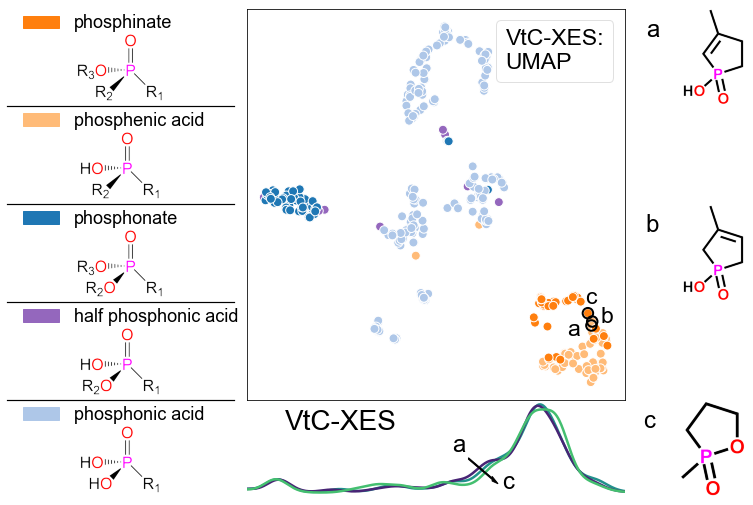

In [17]:
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'half_phosphonic_acid', 'phosphonic_acid']
structures = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]
colorcode, codemap = OHCODES, ohcodemap
N = len(labels)

method = 'UMAP'

########## set up figure with axes
fig = plt.figure(figsize=(14, 9))
ratio = 0.3
spec = fig.add_gridspec(nrows=N*2, ncols=3, width_ratios=[0.6, 1, 0.4],
                        height_ratios=[ratio, 1, ratio, 1, ratio, 1, ratio, 1, ratio, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

########## set up formatting kwargs and variables
kwargs = {'Class': labels, 'loc':1, 'title': ''}

########## get reuced spaces with corresponding maps
# X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
#                                                               method=method, **kwargs)
# X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
#                                                                   method=method, **kwargs)
cid_subset = [c['CID'] for c in X_data_classed if c['Class'] in labels]

########## make first column with structures
for i, structure in enumerate(structures):
    # show structure
    structax = fig.add_subplot(spec[2*i+1,0])
    structax.imshow(structures[i])
    structax.axis('equal')
    # Hide spines
    turn_off_spines(structax)
    turn_off_ticks(structax)
        
    # make legend
    legax = fig.add_subplot(spec[2*i,0])
    patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[i]] - 1),
                              label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.35),
                          fontsize=18, framealpha=0, frameon=False)
    # Hide spines
    set_spine_width(legax, width=1.2)
    turn_off_spines(legax, spines=['bottom','left','right'])
    if i == 0:
        turn_off_spines(legax, spines=['top'])
    turn_off_ticks(legax)
    
########### set-up example settings
select_cids = [98611, 21720419, 104467]
label = ['a', 'b', 'c']
colorcodemap = {98611:0.1, 21720419:0.5, 104467:0.7} 
offsets = [(-18, -14), (15, -5), (3, 5)]
energyrange = (2119, 2142)
tsnemap = XES_tsnemap   

###### spaghetti plot of selected cids
ax = fig.add_subplot(spec[N*2-2:, 1])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES', scalecolor=False,
                                colorcodemap=colorcodemap, colormap=plt.cm.viridis,
                                linewidth=2.5, hiddenalpha=0, coloralpha=1.0, verbose=False,
                                energyrange=energyrange, **Merge(kwargs, options))

###### drawing arrow and annotating
x, y, dx, dy = 2132.5, 1.18, 1.8, -0.13
arr = mpl.patches.Arrow(x, y, dx, dy, width=0.04, linestyle='-',
                        edgecolor='k', facecolor='k', zorder=5)
ax.add_patch(arr)
ax.annotate('a', (x, y), ha='center', va='bottom',
            size=24, xytext=(-10, 2), textcoords='offset points')
ax.annotate('c', (x + dx, y + dy), ha='center', va='bottom',
            size=24, xytext=(10, -10), textcoords='offset points')

######## select options for the 2D plot
options = Merge(kwargs, {'CID': select_cids, 'offsets':offsets, 'label':label})
subax = fig.add_subplot(spec[:N*2-2, 1])
            
#################### tsne plot   
tsne_plt = plot_dim_red((fig, subax), X_subset, tsnemap, size=80, 
                        colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                        mode='XES', method=method, fontsize=23, edgecolors='w',
                        large_ticks=False, **options)

##### show selected cid structures
for i, cid in enumerate(select_cids):
    size = 2
    structax = fig.add_subplot(spec[size*i*2: size*i*2 + size, 2])
    img = Image.open(f"../Figures/chemdraw/{cid}.png")
    structax.imshow(img)
    structax.axis('off')
    structax.annotate(label[i], (0, 0), ha='right', va='top',
                      size=24, xytext=(-0.35, 0.9), textcoords='axes fraction')
        
plt.savefig(f'../Figures/{method}_OH.png', dpi=1000, transparent=False, bbox_inches='tight')

In [ ]:
cid = 312437
C1 = np.array([-0.52751, -0.67727, -1.63603])
C2 = np.array([1.72359, -0.45014, -0.21939])

cosine_angle = np.dot(C1, C2) / (np.linalg.norm(C1) * np.linalg.norm(C2))
angle = np.arccos(cosine_angle)

print(f'{cid}: {np.degrees(angle)} deg')

In [ ]:
cid = 88779457
C1 = np.array([-0.78480, 1.66303, -0.20829])
C2 = np.array([1.57470 , 0.36444, -0.87968])         

cosine_angle = np.dot(C1, C2) / (np.linalg.norm(C1) * np.linalg.norm(C2))
angle = np.arccos(cosine_angle)

print(f'{cid}: {np.degrees(angle)} deg')

In [ ]:
cid = 10397098

C1 = np.array([-1.70869, 0.69843, -0.07240])
C2 = np.array([1.13638, 1.29924, 0.56355])

cosine_angle = np.dot(C1, C2) / (np.linalg.norm(C1) * np.linalg.norm(C2))
angle = np.arccos(cosine_angle)

print(f'{cid}: {np.degrees(angle)} deg')

# Supervised ML Visualization

In [ ]:
# Hyperparameter grid search

In [89]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel

# ndim = 5

# # define model
# model = GaussianProcessClassifier()
# # define model evaluation method
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=42)
# # define grid
# grid = dict()
# grid['kernel'] = [1*RBF(), 1*Matern(),  1*RationalQuadratic(), RationalQuadratic()*Matern()]
# # define search
# search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# for mode in ['XES', 'XANES']:
#     print(f"\n{mode}")

#     for fname, codemap, kwargs in [('oxy_test_cids.txt', classcodemap, {}),
#                                    ('OH_test_cids.txt', ohcodemap, 
#                                        {'Class': ['phosphinate', 'phosphenic_acid', 'phosphonate',
#                                                   'half_phosphonic_acid', 'phosphonic_acid']})]:
#         print(fname)
#         test_map = get_test_map(fname)
#         train_map = get_train_map(codemap, test_map)
#         _, reduced_map, _, _ = get_subset_maps(X_data_classed, codemap, mode=mode,
#                                                method='UMAP', ndim=ndim, **kwargs)

#         xtrain, xval, xtest, ytrain, yval, ytest = get_ML_datasets(train_map, test_map, reduced_map)
#         results = search.fit(xtrain, ytrain)
#         # summarize best
#         print('Best Mean Accuracy: %.3f' % results.best_score_)
#         print('Best Config: %s' % results.best_params_)
#         # summarize all
#         means = results.cv_results_['mean_test_score']
#         params = results.cv_results_['params']
#         for mean, param in zip(means, params):
#             print(">%.3f with: %r" % (mean, param))
#         print('--------------------')

In [90]:
utils = reload(utils)
from utils import *

In [93]:
ndim = 5

Accuracies = [[], []]
Confidence = [[], []]

Schemes = []

X_coord, XES_map, _, _ = get_subset_maps(X_data_classed, coordcodemap,
                                         mode='XES', method='UMAP', ndim=ndim)
X_coord, XANES_map, _, _ = get_subset_maps(X_data_classed, coordcodemap,
                                           mode='XANES', method='UMAP', ndim=ndim)

# coordination
real_coord_map = {1: 3, 3: 4} # from color to coord number
coordination_codemap = {c['CID']:real_coord_map[coordcodemap[c['CID']]] for c in X_coord}

test_map = get_test_map('coord_test_cids.txt')
train_map = get_train_map(coordination_codemap, test_map)
train_GP(XES_map, XANES_map, train_map, test_map, Accuracies, Confidence, validate=False)
Schemes.append('Coordination')

# oxidation
test_map = get_test_map('oxy_test_cids.txt')
train_map = get_train_map(classcodemap, test_map)
train_GP(XES_map, XANES_map, train_map, test_map, Accuracies, Confidence, validate=False)
Schemes.append('Oxidation')

# phosphates
codemap = phosphate_colorcodemap
kwargs = {'Class': ['phosphate']}

X_subset, XES_map, _, _ = get_subset_maps(X_data_classed, codemap, mode='XES',
                                          method='UMAP', ndim=ndim, **kwargs)
X_subset, XANES_map, _, _ = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                            method='UMAP', ndim=ndim, **kwargs)

test_map = get_test_map('phosphate_test_cids.txt')
train_map = get_train_map(codemap, test_map)
train_GP(XES_map, XANES_map, train_map, test_map, Accuracies, Confidence, validate=False)
Schemes.append('Phosphates')

# sulfur
labels = ['phosphate', 'phosphorothioate', 'dithiophosphate']
kwargs = {'Class': labels}
codemap = sulfurcodemap

X_subset, XES_map, _, _ = get_subset_maps(X_data_classed, codemap, mode='XES',
                                          method='UMAP', ndim=ndim, **kwargs)
X_subset, XANES_map, _, _ = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                            method='UMAP', ndim=ndim, **kwargs)
 
test_map = get_test_map('sulfur_test_cids.txt')
train_map = get_train_map(codemap, test_map)
train_GP(XES_map, XANES_map, train_map, test_map, Accuracies, Confidence, validate=False)
Schemes.append('Sulfur ligand')

# OH
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'half_phosphonic_acid', 'phosphonic_acid']
kwargs = {'Class': labels}
codemap = ohcodemap

X_subset, XES_map, _, _ = get_subset_maps(X_data_classed, codemap, mode='XES',
                                          method='UMAP', ndim=ndim, **kwargs)
X_subset, XANES_map, _, _ = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                            method='UMAP', ndim=ndim, **kwargs)

test_map = get_test_map('OH_test_cids.txt')
train_map = get_train_map(codemap, test_map)
train_GP(XES_map, XANES_map, train_map, test_map, Accuracies, Confidence, validate=False)
Schemes.append('Hydroxyl ligand')

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\skl

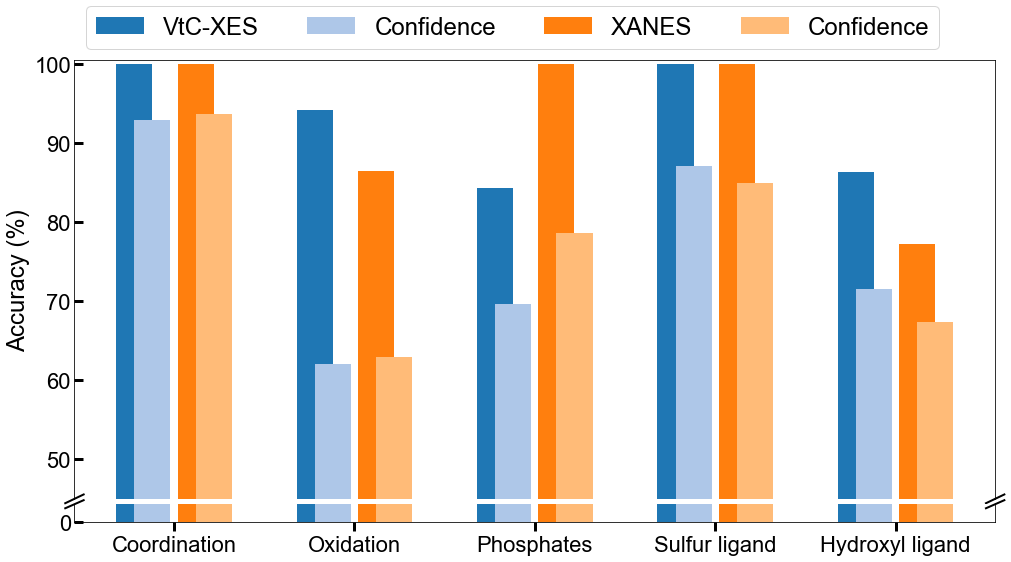

In [94]:
bar_chart(Accuracies, Confidence, Schemes, save=True)